# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [ ]:
import yfinance as yf
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']
start = '2020-04-01'
end = '2022-04-22'
data = yf.download(tickers, start=start, end=end, interval='1d')
closeprices = data['Close']
closeprices = closeprices.dropna()
print(closeprices)

[*********************100%***********************]  6 of 6 completed
              DSKY.ME     GAZP.ME     KMAZ.ME     RASP.ME    RUAL.ME  \
Date                                                                   
2020-04-01  90.120003  180.059998   51.000000   97.760002  24.754999   
2020-04-02  90.620003  187.039993   50.599998   99.400002  24.955000   
2020-04-03  94.419998  189.770004   53.599998   99.099998  24.830000   
2020-04-06  97.800003  191.100006   54.400002  100.919998  25.754999   
2020-04-07  98.120003  191.220001   54.599998   98.980003  26.049999   
...               ...         ...         ...         ...        ...   
2022-04-15  77.720001  224.000000  100.099998  398.600006  66.750000   
2022-04-18  75.599998  216.990005  100.099998  403.149994  64.605003   
2022-04-19  75.199997  220.720001   99.300003  391.149994  63.200001   
2022-04-20  75.980003  218.919998   99.099998  392.000000  63.200001   
2022-04-21  75.180000  218.919998   99.099998  394.000000  63.20000

Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

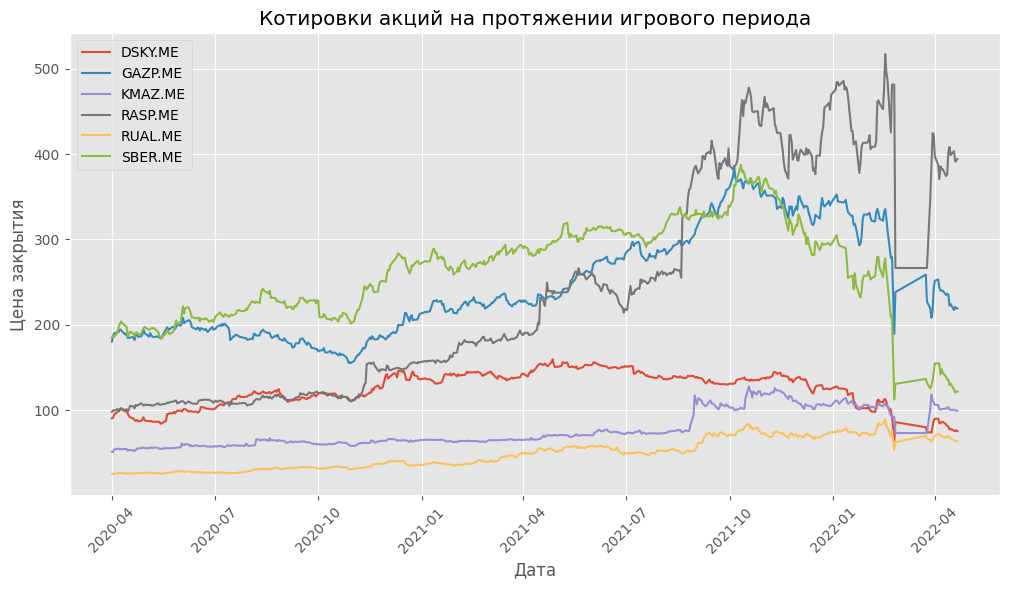

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))

for ticker in closeprices.columns:
    ax.plot(closeprices.index, closeprices[ticker], label=ticker)

ax.set_title('Котировки акций на протяжении игрового периода')
ax.set_xlabel('Дата')
ax.set_ylabel('Цена закрытия')
ax.legend(loc='upper left')
plt.xticks(rotation=45)

plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [ ]:

market_returns = closeprices.pct_change().dropna()
print(market_returns)

             DSKY.ME   GAZP.ME   KMAZ.ME   RASP.ME   RUAL.ME   SBER.ME
Date                                                                  
2020-04-02  0.005548  0.038765 -0.007843  0.016776  0.008079  0.011744
2020-04-03  0.041933  0.014596  0.059289 -0.003018 -0.005009 -0.007007
2020-04-06  0.035798  0.007008  0.014925  0.018365  0.037253  0.027257
2020-04-07  0.003272  0.000628  0.003676 -0.019223  0.011454  0.036340
2020-04-08  0.019160  0.015113 -0.016483  0.017175 -0.011516  0.013459
...              ...       ...       ...       ...       ...       ...
2022-04-15  0.006214  0.008509 -0.001994 -0.023398  0.001500  0.014181
2022-04-18 -0.027277 -0.031295  0.000000  0.011415 -0.032135 -0.053713
2022-04-19 -0.005291  0.017190 -0.007992 -0.029766 -0.021748 -0.028664
2022-04-20  0.010372 -0.008155 -0.002014  0.002173  0.000000  0.009975
2022-04-21 -0.010529  0.000000  0.000000  0.005102  0.000000  0.000000

[502 rows x 6 columns]


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

Для задачи формирования портфеля ценных бумаг, функция потерь f_t(x) может быть определена как отрицательный логарифмический прирост портфеля:

f_t(x) = -ln(x^T * r_t),

где x - вектор распределения средств между активами, r_t - вектор рыночных доходностей в момент времени t.

Чтобы выразить градиент функции потерь f_t(x) по x, нам нужно найти производную функции потерь по каждому компоненту вектора x:

∇f_t(x) = [∂f_t(x)/∂x_1, ∂f_t(x)/∂x_2, ..., ∂f_t(x)/∂x_d],

где d - размерность вектора x (количество активов в портфеле).

Вычисляем производную для каждого компонента:

∂f_t(x)/∂x_i = -1 * (1 / (x^T * r_t)) * r_{t,i},

где r_{t,i} - i-й компонент вектора r_t.

Таким образом, градиент функции потерь f_t(x) имеет следующий вид:

∇f_t(x) = - (r_t / (x^T * r_t)).

Теперь мы можем записать явную формулу для итерации Оnline Gradient Descent (OGD):

x_{t+1} = Proj(Δ^d)(x_t + η * (r_t / (x_t^T * r_t))),

где η - коэффициент скорости обучения (learning rate), Proj(Δ^d) - оператор проекции на стандартный симплекс Δ^d.

Важно отметить, что после каждой итерации OGD, мы должны проецировать обновленный вектор x на стандартный симплекс, чтобы получить допустимое распределение средств между активами.



```
# Выбран кодовый формат
```

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [ ]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [ ]:
def online_gradient_descent_investor(market_returns, learning_rate=0.01, epsilon=1e-8):
    num_assets = market_returns.shape[1]
    num_days = market_returns.shape[0] -1

    x = np.ones(num_assets) / num_assets
    x_history = [x.copy()]
    for t in range(num_days):
        # Получение вектора рыночных доходностей для текущего дня
        r_t = market_returns.iloc[t].values

        # Выполнение итерации онлайн градиентного спуска
        gradient = - (r_t / (np.dot(x, r_t) + epsilon))
        x += learning_rate * gradient

        # Обновление вектора распределения средств с использованием проекции на стандартный симплекс
        x = simplex_projection(x)
        x_history.append(x.copy())

    return np.array(x_history)



### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Для OGD в задаче формирования портфеля ценных бумаг, в литературе(https://courses.cs.washington.edu/courses/cse522/17sp/papers/Shalev-SchwartzOnlineOptimization.pdf) рекомендуется использовать следующее 
значение learning rate :

η = 1 / sqrt(T),

где T - общее количество итераций (дней). Эта рекомендация основана на анализе верхней границы регрета для алгоритма OGD*Место для выкладок.*

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

<ipython-input-39-940f8f7f8a7e>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(wealth)
<ipython-input-39-940f8f7f8a7e>:3: RuntimeWarning: invalid value encountered in log
  return np.log(wealth)


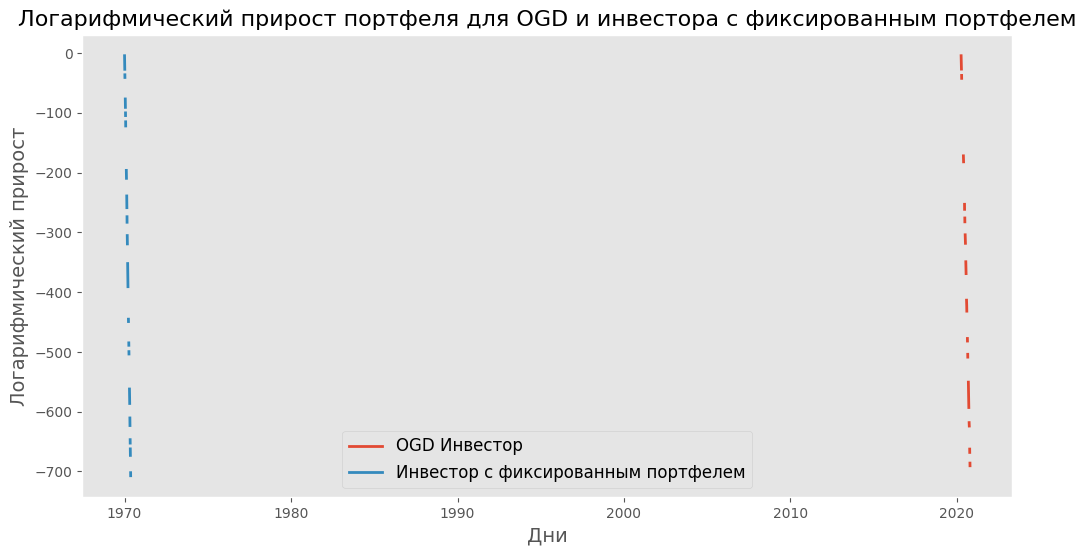

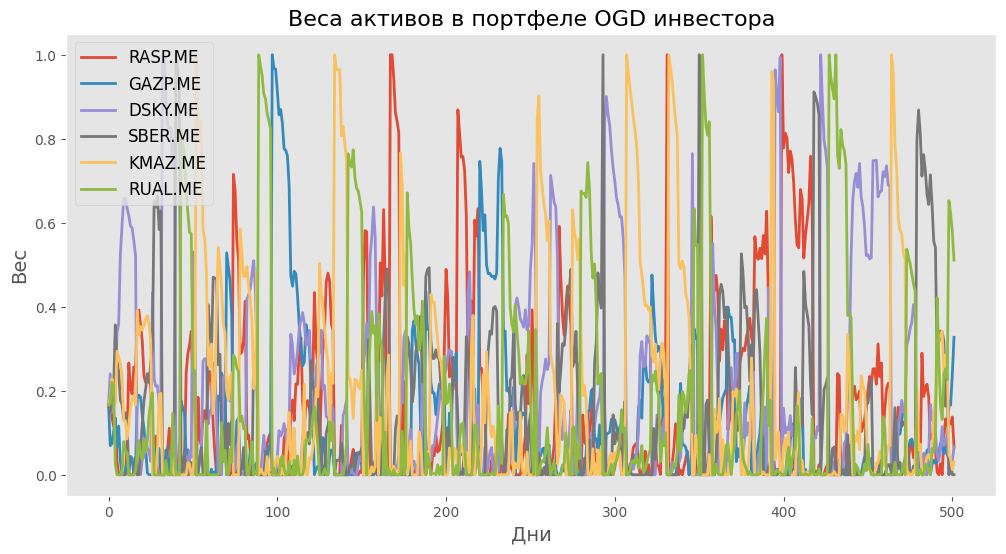

In [ ]:
def fixed_portfolio_investor(market_returns, initial_portfolio):
    wealth = np.cumprod(np.dot(market_returns, initial_portfolio))
    return np.log(wealth)

# Запуск OGD на всем горизонте игры
x_history = online_gradient_descent_investor(market_returns, learning_rate=1/np.sqrt(market_returns.shape[0]))

# Визуализация динамики логарифмического прироста портфеля
ogd_wealth = np.cumprod(np.sum(market_returns * x_history, axis=1))
ogd_log_growth = np.log(ogd_wealth)

# Зафиксированное распределение в начале игры
fixed_portfolio = np.array([1/len(tickers)] * len(tickers))
fixed_log_growth = fixed_portfolio_investor(market_returns, fixed_portfolio)







# Сравнение логарифмического прироста портфеля на отрезке времени
plt.figure(figsize=(12, 6))
plt.plot(ogd_log_growth, label='OGD Инвестор', linewidth=2)
plt.plot(fixed_log_growth, label='Инвестор с фиксированным портфелем', linewidth=2)
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Логарифмический прирост', fontsize=14)
plt.title('Логарифмический прирост портфеля для OGD и инвестора с фиксированным портфелем', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Распределение весов активов в портфеле OGD инвестора по времени
plt.figure(figsize=(12, 6))
for i in range(len(tickers)):
    plt.plot(x_history[:, i], label=tickers[i], linewidth=2)
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Вес', fontsize=14)
plt.title('Веса активов в портфеле OGD инвестора', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

Exponentially Weighted Average (EWA). Он использует взвешенное сглаживание экспоненциально убывающих весов для адаптации к изменяющимся условиям рынка.

Код реализации алгоритма EWA:

In [ ]:
def online_ewa_investor(market_returns, learning_rate=0.1, gamma=0.95):
    n_days, n_assets = market_returns.shape
    x = np.ones(n_assets) / n_assets  # начальное распределение по активам
    x_history = [x]
    log_growth = np.zeros(n_days)
    w = np.ones(n_assets) / n_assets  # начальные веса для EWA
    for t in range(n_days):
        r_t = market_returns[t]
        x_t = np.dot(x, r_t)  # текущее состояние портфеля
        log_growth[t] = np.log(np.dot(x, r_t))  # логарифмический прирост портфеля
        w = gamma * w + (1 - gamma) * r_t
        gradient = - r_t / x_t  # градиент функции потерь
        x = x * np.exp(-learning_rate * gradient)  # обновляем распределение портфеля
        x /= np.sum(x)  # проекция на симплекс
        x_history.append(x)
    return np.array(x_history), log_growth

In [ ]:
# запускаем алгоритмы
x_history = online_gradient_descent_investor(market_returns, learning_rate=1/np.sqrt(market_returns.shape[0]))
ogd_wealth = np.cumprod(np.sum(market_returns * x_history, axis=1))
ogd_log_growth = np.log(ogd_wealth)

x_ewa, log_growth_ewa = online_ewa_investor(market_returns, learning_rate=0.01, gamma=0.95)


plt.figure(figsize=(12, 6))
plt.plot(ogd_log_growth, label='OGD Инвестор', linewidth=2)
plt.plot(log_growth_ewa, label='EWA Инвестор', linewidth=2)
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Логарифмический прирост', fontsize=14)
plt.title('Логарифмический прирост портфеля для OGD и EWA Инвестора', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()


KeyError: ignored